In [1]:
!pip install faiss-cpu -q
!pip install git+https://github.com/cvg/LightGlue.git -q
!pip install pycolmap -q

!mkdir -p /root/.cache/torch/hub/checkpoints
# !cp -r /kaggle/working/.local/lib/python*/site-packages/* offline_packages/

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 56.0 MB/s eta 0:00:00:00:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 106.0 MB/s eta 0:00:0000:010:01


In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm
from itertools import combinations
import h5py
import dataclasses

import cv2
from PIL import Image

import torch
from transformers import AutoImageProcessor, AutoModel
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
from typing import Optional, Tuple
import torch.nn.functional as F

import faiss
import networkx as nx
from community import community_louvain

from lightglue import LightGlue, SuperPoint, ALIKED
import pycolmap
from torchvision import transforms as T

import sys
sys.path.append("/kaggle/input/imc25-utils")

from database import *
from h5_to_db import *
import metric
import shutil

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

2025-06-10 16:39:26.107721: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749573566.282515      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749573566.332516      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/lightglue/lightglue.py:24: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


In [3]:
# load the csv's
df_tl = pd.read_csv("/kaggle/input/image-matching-challenge-2025/train_labels.csv")
df_tt = pd.read_csv("/kaggle/input/image-matching-challenge-2025/train_thresholds.csv")
df_ss = pd.read_csv("/kaggle/input/image-matching-challenge-2025/sample_submission.csv")

In [4]:
# print("train_labels.csv")
# print(df_tl.info())
# print(df_tl.head())
# print()

# print("train_thresholds.csv")
# print(df_tt.info())
# print(df_tt.head(5))
# print()

# print("sample_submission.csv")
# print(df_ss.info())
# print(df_ss.head(5))
# print()


## STEP 1

In [5]:
# to extract  global feature using DINO Vision Transformers (ViTs)
all_features = []
image_paths = []

def global_feature_extractor(
    device, 
    Dataloader,
    verbose = True,
    pooling = 'mac',
    model_path = '/kaggle/input/dinov2/pytorch/large/1'):
    
    assert pooling in ["mac", "cls"], "Pooling must be 'mac' or 'cls'"
    loop = tqdm(Dataloader, desc="Extracting DINO features", disable=not verbose)
    
    processor = AutoImageProcessor.from_pretrained(model_path,use_fast=True)
    dino_model = AutoModel.from_pretrained(model_path)
    dino_model = dino_model.eval().to(device)
    
    with torch.inference_mode():
        feature_list = []
        for images, metadata in loop:
            inputs = processor(images=images, return_tensors="pt",do_rescale=False).to(device)
            outputs = dino_model(**inputs)
            if pooling == 'mac':
                # last_hidden_state shape: (batch_size, sequence_length, hidden_dim)
                vec = F.normalize(outputs.last_hidden_state[:,1:].max(dim=1)[0], dim=1, p=2) #all
            else:
                vec = F.normalize(outputs.last_hidden_state[:,0], dim=1, p=2) # batch, hidden_dim
            feature_list.append(vec.detach().cpu())
            image_paths.extend(metadata['image_path'])
            
        all_feature_list = torch.cat(feature_list, dim=0)
        
    return all_feature_list.numpy(), image_paths
    
    
    

In [6]:
# to build FAISS knn graph from global features
def build_knn_graph(features, data_dir, img_paths, k=10):
    """
    Build a kNN graph using cosine similarity and per-scene threshold filtering.
    
    features: np.ndarray of global descriptors
    img_paths: List of paths aligned with features
    scene_thresholds: Dict[scene_name] -> float (e.g., lowest accepted threshold)
    k: number of neighbors

    Returns:
        List of (i, j, sim) edges that pass scene threshold check
    """
    def load_threshold(dir):
        """
        return threshold value per scene in a Dict
        """
        threshold = os.path.join(data_dir, "train_thresholds.csv")
        thresh_df = pd.read_csv(threshold)
        tdict = dict()
        for _, row in thresh_df.iterrows():
            tdict[row["scene"]] = float(row['thresholds'].split(';')[-1])
            
        return tdict
    
    
    features = features.astype(np.float32)
    features /= np.linalg.norm(features, axis=1, keepdims=True)

    index = faiss.IndexFlatIP(features.shape[1])  # inner product = cosine sim if normalized
    index.add(features)
    distances, indices = index.search(features, k + 1)  # +1 because self-match at index 0

    paths = [os.path.dirname(p).split("/")[-1] for p in img_paths]
    og_scene_threshold = load_threshold(data_dir)


    edges = []
    num_points = features.shape[0]
    for i in range(num_points):
        for j in range(1, k + 1):  # skip self-match
            neighbor = indices[i][j]
            sim = distances[i][j]

            scene_1 = paths[i]
            scene_2 = paths[neighbor]

            if scene_1 == scene_2:
                threshold = og_scene_threshold.get(scene_1, 0.1)
                if sim >= threshold:
                    edges.append((i, neighbor, sim))
                else:
                    continue

    return edges
    

In [7]:
def build_graph_from_edges(edges):
    """
    Builds a weighted undirected NetworkX graph from edge list (i, j, weight)
    """
    G = nx.Graph()
    for i, j, sim in edges:
        G.add_edge(i, j, weight=sim)
    return G

def louvian_cluster(graph):
    return community_louvain.best_partition(graph,weight = 'weight')
    

## STEP 2

In [8]:
# def convert_img_alkeid(img_path,device=torch.device('cpu')):
#     img = Image.open(img_path).convert("RGB")
#     img = T.ToTensor()(img).to(device) 
#     return img.unsqueeze(0).to(torch.float32)

# def make_h5_key(img_path):
#     scene = img_path.split("/")[-2]
#     return os.path.join(scene, os.path.basename(img_path))

# def detect_aliked(img_fnames, 
#                   feature_dir, 
#                   num_features=4096, 
#                   resize_to=1024, 
#                   device=torch.device('cpu')): # alkeid is strictly cpu due to its imported lib
    
#     dtype = torch.float32
#     extractor = ALIKED(max_num_keypoints=num_features, detection_threshold=0.3, 
#                        resize=resize_to).eval().to(device, dtype)
    
#     os.makedirs(feature_dir, exist_ok=True)

#     with h5py.File(f'{feature_dir}/keypointsal.h5', 'a') as f_kp, \
#          h5py.File(f'{feature_dir}/descriptorsal.h5', 'a') as f_desc:

#         for img_path in tqdm(img_fnames, desc="Extracting ALIKED"):            
#             key = make_h5_key(img_path)
#             if key in f_kp and key in f_desc:
#                 continue  # skip if already extracted
#             with torch.inference_mode():
#                 image_tensor = convert_img_alkeid(img_path)
#                 feats = extractor.extract(image_tensor)
#                 kpts = feats['keypoints'].reshape(-1, 2).cpu().numpy()
#                 descs = feats['descriptors'].reshape(len(kpts), -1).cpu().numpy()
#                 f_kp[key] = kpts
#                 f_desc[key] = descs
#     return 

In [9]:
# def match_with_lightglue_native(kp1, kp2, desc1, desc2, device):
#     matcher = LightGlue(features="aliked").eval().to(device)
#     with torch.inference_mode():
#         matches = matcher({
#             "image0": {
#                 "keypoints": kp1[None].to(device),
#                 "descriptors": desc1[None].to(device),
#             },
#             "image1": {
#                 "keypoints": kp2[None].to(device),
#                 "descriptors": desc2[None].to(device),
#             }
#         })
#     matches0 = matches["matches0"].cpu().numpy()
#     valid = matches0 > -1
#     idx0 = np.where(valid)[0]
#     idx1 = matches0[valid]
#     return np.stack([idx0, idx1], axis=1)


# def match_with_lightglue(img_fnames, 
#                          index_pairs, 
#                          feature_dir, 
#                          device = torch.device("cuda" if torch.cuda.is_available() else "cpu"), 
#                          min_matches=20):

#     with h5py.File(f'{feature_dir}/keypointsal.h5', 'r') as f_kp, \
#          h5py.File(f'{feature_dir}/descriptorsal.h5', 'r') as f_desc, \
#          h5py.File(f'{feature_dir}/matchesal.h5', 'a') as f_match:

#         for idx1, idx2 in tqdm(index_pairs, desc="Matching LightGlue"):
#             scene =  img_fnames[idx1].split("/")[-2]
#             fname1 = os.path.basename(img_fnames[idx1])
#             fname2 = os.path.basename(img_fnames[idx2])
#             key1 = f"{scene}/{fname1}"
#             key2 = f"{scene}/{fname2}"

#             if key1 in f_match and key2 in f_match[key1]:
#                 continue

#             kp1 = torch.from_numpy(f_kp[key1][...])
#             kp2 = torch.from_numpy(f_kp[key2][...])
#             desc1 = torch.from_numpy(f_desc[key1][...])
#             desc2 = torch.from_numpy(f_desc[key2][...])

#             idxs = match_with_lightglue_native(kp1, kp2, desc1, desc2, device)

#             if len(idxs) < min_matches:
#                 continue

#             scene_group = f_match.require_group(scene)  # First ensure scene exists
#             image_group = scene_group.require_group(fname1)  # Group for image1
#             image_group.create_dataset(fname2, data=idxs)  # Store match with image2

#             # print(image_group)
#     return 


In [10]:
# with h5py.File('/kaggle/working/result/featureout/matchesal.h5', 'r') as f:
#     for group, val in f.items():
#         print(group, val)
#         for key, item in f[group].items():
#             print(key, item)
#             for key2 in f[group][key]:
#                 print(key2)
#             break
        
        

In [11]:
def convert_img_super(img_path,device=torch.device('cpu')):
    img = Image.open(img_path).convert("RGB")
    img = T.ToTensor()(img).to(device) 
    return img.unsqueeze(0).to(torch.float32)

def make_h5_key(img_path):
    scene = img_path.split("/")[-2]
    return os.path.join(scene, os.path.basename(img_path))

def detect_superpoint(img_fnames, 
                  feature_dir, 
                  num_features=4096, 
                  resize_to=1024, 
                  device=torch.device('cpu')): # alkeid is strictly cpu due to its imported lib
    
    dtype = torch.float32
    extractor = SuperPoint(max_num_keypoints=4096).eval().to(device, dtype)
    
    os.makedirs(feature_dir, exist_ok=True)

    with h5py.File(f'{feature_dir}/keypoints.h5', 'a') as f_kp, \
         h5py.File(f'{feature_dir}/descriptors.h5', 'a') as f_desc:

        for img_path in tqdm(img_fnames, desc="Extracting Superpoint"):            
            key = make_h5_key(img_path)
            if key in f_kp and key in f_desc:
                continue  # skip if already extracted
            with torch.inference_mode():
                image_tensor = convert_img_super(img_path)
                feats = extractor.extract(image_tensor)
                kpts = feats['keypoints'].reshape(-1, 2).cpu().numpy()
                descs = feats['descriptors'].reshape(len(kpts), -1).cpu().numpy()
                f_kp[key] = kpts
                f_desc[key] = descs
    return 

In [12]:
def match_with_lightglue_native_super(kp1, kp2, desc1, desc2, device):
    matcher = LightGlue(features='superpoint').eval().to(device)
    with torch.inference_mode():
        matches = matcher({
            "image0": {
                "keypoints": kp1[None].to(device),
                "descriptors": desc1[None].to(device),
            },
            "image1": {
                "keypoints": kp2[None].to(device),
                "descriptors": desc2[None].to(device),
            }
        })
    matches0 = matches["matches0"].cpu().numpy()
    valid = matches0 > -1
    idx0 = np.where(valid)[0]
    idx1 = matches0[valid]
    return np.stack([idx0, idx1], axis=1)


def match_with_lightglue_sup(img_fnames, 
                         index_pairs, 
                         feature_dir, 
                         device = torch.device("cuda" if torch.cuda.is_available() else "cpu"), 
                         min_matches=20):

    with h5py.File(f'{feature_dir}/keypoints.h5', 'r') as f_kp, \
         h5py.File(f'{feature_dir}/descriptors.h5', 'r') as f_desc, \
         h5py.File(f'{feature_dir}/matches.h5', 'a') as f_match:

        for idx1, idx2 in tqdm(index_pairs, desc="Matching LightGlue"):
            scene =  img_fnames[idx1].split("/")[-2]
            fname1 = os.path.basename(img_fnames[idx1])
            fname2 = os.path.basename(img_fnames[idx2])
            key1 = f"{scene}/{fname1}"
            key2 = f"{scene}/{fname2}"

            if scene in f_match and fname1 in f_match[scene] and fname2 in f_match[scene][fname1]:
                continue

            kp1 = torch.from_numpy(f_kp[key1][...])
            kp2 = torch.from_numpy(f_kp[key2][...])
            desc1 = torch.from_numpy(f_desc[key1][...])
            desc2 = torch.from_numpy(f_desc[key2][...])

            idxs = match_with_lightglue_native_super(kp1, kp2, desc1, desc2, device)

            if len(idxs) < min_matches:
                continue

            scene_group = f_match.require_group(scene)  # First ensure scene exists
            image_group = scene_group.require_group(fname1)  # Group for image1
            image_group.create_dataset(fname2, data=idxs.astype(np.int32))  # Store match with image2

            # print(image_group)
    return 


In [13]:
# with h5py.File('/kaggle/working/result/featureout/matchesup.h5', 'r') as f:
#     for group, val in f.items():
#         print(group, val)
#         for key, item in f[group].items():
#             print(key, item)
#             for key2 in f[group][key]:
#                 print(key2)
            

In [14]:
def ransac_on_matches(kp1, kp2, match_idx, threshold=1.0):
    """
    Run RANSAC filtering on keypoint matches.
    kp1, kp2: [N, 2] keypoints
    match_idx: [M, 2] indices (i1, i2)
    Returns: inlier matches (subset of match_idx)
    """
    pts1 = kp1[match_idx[:, 0]]
    pts2 = kp2[match_idx[:, 1]]
    
    if len(pts1) < 8:
        return np.empty((0, 2), dtype=np.int32)

    F, mask = cv2.findFundamentalMat(pts1, pts2, method=cv2.RANSAC, ransacReprojThreshold=threshold)

    if mask is None:
        return np.empty((0, 2), dtype=np.int32)

    inliers = match_idx[mask.ravel().astype(bool)]
    return inliers


# def geometric_ransac(feature_dir, output_h5='inliers.h5', device=torch.device('cpu')):
#     with h5py.File(f'{feature_dir}/keypoints.h5', 'r') as f_kp, \
#          h5py.File(f'{feature_dir}/matches.h5', 'r') as f_match, \
#          h5py.File(f'{feature_dir}/{output_h5}', 'a') as f_inliers:
#             for fname1 in tqdm(f_match.keys(), desc='RANSAC Filtering'):
#                 for fname2 in f_match[fname1].keys():
#                     print(fname1, fname2)
#                     if fname1 in f_inliers and fname2 in f_inliers[fname1]:
#                         continue
    
#                     try:
#                         kp1 = f_kp[fname1][...]
#                         kp2 = f_kp[fname2][...]
#                     except Exception as e:
#                         print(f"Error reading {fname1} or {fname2}:", e)
#                         continue
    
#                     match_idx = f_match[fname1][fname2][...]
#                     inliers = ransac_on_matches(kp1, kp2, match_idx)
    
#                     if len(inliers) < 8:
#                         continue
    
#                     f_inliers.require_group(fname1).create_dataset(fname2, data=inliers)


def geometric_ransac(feature_dir, output_h5='inliers.h5', device=torch.device('cpu')):
    with h5py.File(f'{feature_dir}/keypoints.h5', 'r') as f_kp, \
         h5py.File(f'{feature_dir}/matches.h5', 'r') as f_match, \
         h5py.File(f'{feature_dir}/{output_h5}', 'a') as f_inliers:
             for group in tqdm(f_match.keys(), desc="RANSAC filter"):
                 for fname1 in f_match[group].keys():
                     for fname2 in f_match[group][fname1]:
                         if fname1 in f_inliers and fname2 in f_inliers[fname1]:
                             continue
                         key1 = f"{group}/{fname1}"
                         key2 = f"{group}/{fname2}"
                         try:
                            kp1 = f_kp[key1][...]
                            kp2 = f_kp[key2][...]
                            match_idx = f_match[group][fname1][fname2][...]
                         except Exception as e:
                            print(f"Error reading {fname1} or {fname2}:", e)
                            continue
                        
                         inliers = ransac_on_matches(kp1, kp2, match_idx)
                         if len(inliers) < 8:
                            continue
                         scene_group = f_inliers.require_group(group)  # First ensure scene exists
                         image_group = scene_group.require_group(fname1)  # Group for image1
                         image_group.create_dataset(fname2, data=inliers)  # Store match with image2
                         # f_inliers.require_group(scene).create_dataset(fname2, data=inliers)                         
    

## Step 3


In [15]:
# # colemap
# def colmap_reconstruction(image_list, feature_dir, output_dir, intrinsics, 
#                           keypoints_h5="keypoints.h5", matches_h5="inliers.h5", 
#                           min_model_size=8):
#     os.makedirs(output_dir, exist_ok=True)
#     database_path = os.path.join(output_dir, "colmap.db")
    
#     # SubStep 1: Create database
#     if os.path.exists(database_path):
#         os.remove(database_path)
#     COLMAPDatabase.connect(database_path).create_tables()

#     #SubStep2 : Import Camera Module
#     import_into_colmap(
#         img_dir=images_dir,
#         feature_dir=feature_dir,
#         database_path=database_path,
#         img_ext=".png"  # ".jpg" 
#     )

#     # Step 4: Run SfM
#     maps = pycolmap.incremental_mapping(
#         database_path=database_path,
#         image_path=os.path.dirname(image_list[0]),
#         output_path=output_dir,
#         options=pycolmap.IncrementalPipelineOptions(
#             min_model_size=min_model_size
#         )
#     )

#     return maps

In [16]:
def run_colmap_reconstruction(
    image_list,
    feature_dir,
    cluster_id,
    output_root
):
    """
    Performs COLMAP-based SfM for a given cluster.
    Steps:
      - Creates a working directory
      - Copies required feature files and renames inliers.h5 → matches.h5
      - Imports images, keypoints, matches into COLMAP
      - Runs incremental mapping
      - Returns pose dictionary per image (rotation, translation)
    """

    # === Paths ===
    os.makedirs(output_root, exist_ok=True)

    db_path = os.path.join(output_root, "colmap.db")
    print(db_path)
    if os.path.exists(db_path):
        os.remove(db_path)
    img_set = set(os.path.relpath(p,start="/kaggle/input/image-matching-challenge-2025/train") 
                  for p in image_list)

    def add_keypoints_flat(db, feature_dir, img_root, img_ext, camera_model, single_camera):
        f_kp = h5py.File(os.path.join(feature_dir, "keypoints.h5"), "r")
        fname_to_id = {}
        camera_id = None
        # count = 0
        
        for scene in f_kp:
            for key in f_kp[scene]:
                full_img_path = os.path.join(img_root, f"{scene}/{key}")
                if not os.path.isfile(full_img_path):
                    raise IOError(f'Invalid image path {full_img_path}')
                scene_img_path = f"{scene}/{key}"
                keypoints = f_kp[scene][key][()]
                
                # if scene_img_path not in img_set:
                #     continue
                if len(keypoints) == 0:
                    print(f"for scene {scene} 0 keypoints")
                    continue
                if camera_id is None or not single_camera:
                    camera_id = create_camera(db, full_img_path, camera_model)
                    
                image_id = db.add_image(scene_img_path, camera_id)
                db.add_keypoints(image_id, keypoints)
                # count+=1
                # if count <= 15:
                #     print(scene_img_path)
                fname_to_id[scene_img_path] = image_id
    
        return fname_to_id


    def add_matches_flat(db, feature_dir, fname_to_id):
        # print(fname_to_id)
        f_match = h5py.File(os.path.join(feature_dir, "inliers.h5"), "r")
        added = set()
        n_total  = 0
        valid_pairs = 0
    
        # Estimate total number of match entries for tqdm
        n_total = sum((len(f_match[g]) * (len(f_match[g]) - 1)) // 2 for g in f_match)

        # count = 0
        with tqdm(total=n_total, desc="Importing Matches") as pbar:
            for scene in f_match:
                scene_group = f_match[scene] 
                for img1 in scene_group.keys():
                    key1 = f"{scene}/{img1}"
                    key_group = f_match[scene][img1] 
                    for img2 in key_group.keys():
                        key2 = f"{scene}/{img2}"
                        # count += 1
                        # if count<= 10:
                            # print(key1, key2)
    
                        if key1 not in fname_to_id or key2 not in fname_to_id:
                            pbar.update(1)
                            continue
    
                        id1 = fname_to_id[key1]
                        id2 = fname_to_id[key2]
                        pair_id = image_ids_to_pair_id(id1, id2)
                        if pair_id in added:
                            pbar.update(1)
                            continue
                        count = 0 
                        matches = f_match[scene][img1][img2][()]
                        if matches.shape[0] == 0 or matches.ndim != 2 or matches.shape[1]!=2:
                            pbar.update(1)
                            continue
                        if matches.dtype != np.int32 :
                            matches = matches.astype(np.int32)
                        # to remove duplicates
                        _, unique_indices = np.unique(matches[:, 0], return_index=True)
                        matches = matches[sorted(unique_indices)]

                        # print(f"Adding match: {key1} ↔ {key2}, shape: {matches.shape}, dtype: {matches.dtype}") # sanity check
                        db.add_matches(id1, id2, matches)
                        added.add(pair_id)
                        pbar.update(1)
                        valid_pairs += 1
        print(f"[DEBUG] Total valid pairs added to DB: {valid_pairs}")
                        

    
    def import_into_colmap(img_list, feature_dir, database_path):
        
        db = COLMAPDatabase.connect(database_path)
        db.create_tables()
        
        fname_to_id = add_keypoints_flat(
            db,
            feature_dir,
            img_root="/kaggle/input/image-matching-challenge-2025/train",
            img_ext=".png", camera_model='simple-pinhole', single_camera=False)
    
        add_matches_flat(
            db,
            feature_dir,
            fname_to_id
        )
    
        db.commit()
        return
    
    import_into_colmap(image_list, feature_dir, db_path)
    image_dir = "/kaggle/input/image-matching-challenge-2025/train"

    # # === Step 3: Incremental SfM ===
    
    maps = dict()
    mapper_options = pycolmap.IncrementalPipelineOptions()
    mapper_options.min_model_size = 8
    mapper_options.max_num_models = 25 
    
    maps = pycolmap.incremental_mapping(
        database_path=db_path,
        image_path=image_dir,
        output_path=output_root,
        options=mapper_options
    )


    return maps

In [17]:
@dataclasses.dataclass
class Predictions:
    image_id: Optional[str]  # test mode only
    dataset: str
    filename: str
    cluster_index: Optional[int] = None
    rotation: Optional[np.ndarray] = None
    translation: Optional[np.ndarray] = None

image_dir = "/kaggle/input/image-matching-challenge-2025/"
res_dir = "/kaggle/working/result"
to_train = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
to_train = True
train_csv = os.path.join(image_dir,'train_labels.csv')
feature_dir = os.path.join(res_dir, 'featureout')
colmap_output_dir = os.path.join(res_dir, "output/colmap")
# print(device)

In [18]:
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [19]:
# dataloader for the whole pipeline
class ImageMatching():
    def __init__(
        self,
        csv_path: str,
        image_dir: str,
        to_train: bool = True,
        datasets_filter: Optional[list] = None,
        image_transform: Optional[transforms.Compose] = None
        ):
        self.data = []
        self.is_train = to_train
        self.data_dir = image_dir
        self.image_transform = image_transform 
        df = pd.read_csv(csv_path)

        for _, row in df.iterrows():
            if row['dataset'] in datasets_filter:
                entry = {
                    'dataset': row['dataset'],
                    'scene': row['scene'],
                    'filename': row['image'],
                    'image_id': row.get('image_id', None),  
                    'rotation': row.get('rotation_matrix', None) if to_train else None,
                    'translation': row.get('translation_vector', None) if to_train else None,
                }
                self.data.append(entry)
            

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx:int):
        entry = self.data[idx]
        base_dir = 'train' if self.is_train else 'test'
        image_path = os.path.join(self.data_dir, base_dir, entry['dataset'], entry['filename'])
        img = Image.open(image_path).convert("RGB")
        img = self.image_transform(img)

        metadata = {
            'image_path': image_path,
            'dataset': entry['dataset'],
            'scene': entry['scene'],
            'filename': entry['filename'],
        }

        if not self.is_train:
            metadata['image_id'] = entry['image_id']
                
        else:
            metadata['rotation_matrix'] = entry['rotation']
            metadata['translation_vector'] = entry['translation']
        
        return img, metadata
        

In [20]:
#to pass in the images
dataset = ImageMatching(
            train_csv,
            image_dir,
            to_train,
            datasets_filter=['imc2023_haiper','stairs'], #'imc2023_haiper','stairs''imc2024_dioscuri_baalshamin','imc2023_theather_imc2024_church'
            image_transform= image_transform)

train_Dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

# for img_tensor, meta in train_Dataloader:
#     print(meta['filename'])
#     print(meta['image_path'])
#     print(img_tensor.shape)    
#     break
 

In [21]:
feature, img_paths = global_feature_extractor(device, train_Dataloader)
edges = build_knn_graph(feature, image_dir, img_paths, k=10)
Graph = build_graph_from_edges(edges)
cluster_map = louvian_cluster(Graph)        

Extracting DINO features: 100%|██████████| 7/7 [00:26<00:00,  3.83s/it]


In [22]:
clusters = defaultdict(list)
for idx, cluster_id in cluster_map.items():
    clusters[cluster_id].append(img_paths[idx])

In [23]:

def plot_tsne(features, cluster_labels=None, perplexity=30):
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    tsne_proj = tsne.fit_transform(features)

    plt.figure(figsize=(10, 8))
    if cluster_labels is not None:
        sns.scatterplot(x=tsne_proj[:, 0], y=tsne_proj[:, 1], hue=cluster_labels, palette='tab10', s=40)
    else:
        plt.scatter(tsne_proj[:, 0], tsne_proj[:, 1], s=10)
    plt.title("t-SNE of DINO Features")
    plt.show()


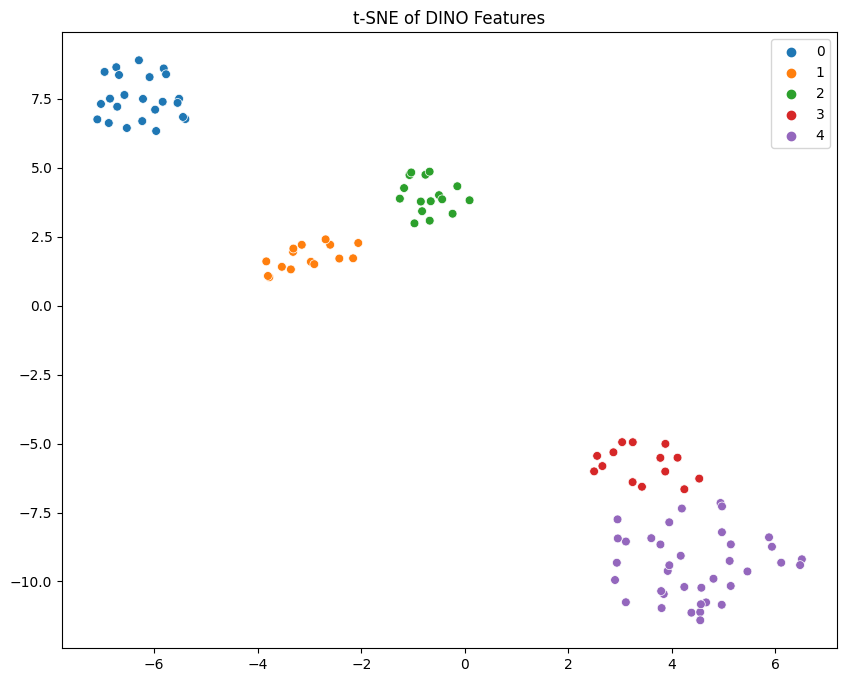

In [24]:
cluster_ids = [cluster_map[i] for i in range(len(feature))]
plot_tsne(feature, cluster_labels=cluster_ids)

In [25]:
# O(n**2) approach due to combination from itertools, numpy one should be prefered for more than 300 imgs in 1 cluster
def get_cluster_index_pairs(img_paths, full_list):
    """
    Given a list of image paths in a cluster and the full dataset image list,
    return index pairs (i, j) for matching.
    """
    idx_map = {path: i for i, path in enumerate(full_list)}
    index_pairs = []
    for img1, img2 in combinations(img_paths, 2):
        index_pairs.append((idx_map[img1], idx_map[img2]))
    return index_pairs

In [26]:
# step2
all_pairs = []
for idx, cluster_imgpath in clusters.items():    
    print(f"Processing cluster {idx} with {len(cluster_imgpath)} images")
    if len(cluster_imgpath) < 2:
        continue
    pairs = get_cluster_index_pairs(cluster_imgpath, img_paths)
    all_pairs.extend(pairs)

detect_superpoint(img_fnames = img_paths, feature_dir = feature_dir) #aliked

match_with_lightglue_sup(
    img_fnames=img_paths,           # full image path list
    index_pairs=all_pairs,          # only intra-cluster pairs
    feature_dir=feature_dir
) # lightglue

geometric_ransac(feature_dir = feature_dir) # ransac

Processing cluster 0 with 23 images
Processing cluster 1 with 15 images
Processing cluster 2 with 16 images
Processing cluster 3 with 14 images
Processing cluster 4 with 37 images


Downloading: "https://github.com/cvg/LightGlue/releases/download/v0.1_arxiv/superpoint_v1.pth" to /root/.cache/torch/hub/checkpoints/superpoint_v1.pth
100%|██████████| 4.96M/4.96M [00:00<00:00, 273MB/s]
Matching LightGlue:   0%|          | 0/1235 [00:00<?, ?it/s]Downloading: "https://github.com/cvg/LightGlue/releases/download/v0.1_arxiv/superpoint_lightglue.pth" to /root/.cache/torch/hub/checkpoints/superpoint_lightglue_v0-1_arxiv.pth

  0%|          | 0.00/45.3M [00:00<?, ?B/s]
100%|██████████| 45.3M/45.3M [00:00<00:00, 352MB/s]
RANSAC filter: 100%|██████████| 2/2 [00:01<00:00,  1.36it/s]


In [27]:
# for cluster_idx, cluster_imgpath in tqdm(clusters.items(), desc="Running COLMAP per cluster"):
#     print(f"{cluster_idx}:{cluster_imgpath}")

In [28]:
# keypoint_f = h5py.File(os.path.join('/kaggle/working/result/featureout', 'keypoints.h5'), 'r')
# count = 0
# for filename in tqdm(list(keypoint_f.keys())):
#     # keypoints = keypoint_f[filename][()]
#     print(filename)
#     print(keypoint_f[filename].items())
#     print(type(filename))
#     print(os.path.join('/kaggle/input/image-matching-challenge-2025/train', filename))
#     count+= 1
#     if count ==5:
#         break
# for scene in keypoint_f:
#     for key in keypoint_f[scene]:
#         kpts = keypoint_f[scene][key][()]
#         print(f"{scene}/{key} → keypoints.shape = {kpts.shape}")

In [29]:
# colmap implementation
#intrinsics = [2048, 2048, 1024, 1024] # [fx,fy, cx, cy] approximates 
pose_dict = defaultdict(dict)

for cluster_idx, cluster_imgpath in tqdm(clusters.items(), desc="Running COLMAP per cluster"):
    
    output_dir = os.path.join(colmap_output_dir, f"cluster_{cluster_idx}")
    print(output_dir)
    maps = run_colmap_reconstruction(
    cluster_imgpath,
    feature_dir,
    cluster_idx,
    output_dir
    )    
    
    # Extract pose from mapped images
    for model_id, model in tqdm(maps.items(), desc = "Pose Extraction"):
        for image_id, image in model.images.items():
            pose_dict[cluster_idx][image.name] = {
                "rotation": image.cam_from_world.rotation.matrix(),
                "translation": image.cam_from_world.translation
            }
print(pose_dict)


Running COLMAP per cluster:   0%|          | 0/5 [00:00<?, ?it/s]

/kaggle/working/result/output/colmap/cluster_0
/kaggle/working/result/output/colmap/cluster_0/colmap.db



Running COLMAP per cluster:   0%|          | 0/5 [00:07<?, ?it/s]


Adding match: imc2023_haiper/bike_image_004.png ↔ imc2023_haiper/bike_image_101.png, shape: (1, 2), dtype: int32
Adding match: imc2023_haiper/bike_image_029.png ↔ imc2023_haiper/bike_image_004.png, shape: (1, 2), dtype: int32
Adding match: imc2023_haiper/bike_image_029.png ↔ imc2023_haiper/bike_image_038.png, shape: (1, 2), dtype: int32
Adding match: imc2023_haiper/bike_image_029.png ↔ imc2023_haiper/bike_image_049.png, shape: (1, 2), dtype: int32
Adding match: imc2023_haiper/bike_image_038.png ↔ imc2023_haiper/bike_image_004.png, shape: (1, 2), dtype: int32
Adding match: imc2023_haiper/bike_image_038.png ↔ imc2023_haiper/bike_image_049.png, shape: (1, 2), dtype: int32
Adding match: imc2023_haiper/bike_image_049.png ↔ imc2023_haiper/bike_image_004.png, shape: (1, 2), dtype: int32
Adding match: imc2023_haiper/bike_image_062.png ↔ imc2023_haiper/bike_image_029.png, shape: (1, 2), dtype: int32
Adding match: imc2023_haiper/bike_image_062.png ↔ imc2023_haiper/bike_image_128.png, shape: (1, 

AttributeError: 'pycolmap._core.IncrementalPipelineOptions' object has no attribute 'use_two_view_geometry'

In [ ]:
# Store it in prediction class 
# for dataset, predictions in samples.items():
#     for pred in predictions:
#         fname = pred.filename
#         for cluster_id in pose_dict:
#             if fname in pose_dict[cluster_id]:
#                 pose = pose_dict[cluster_id][fname]
#                 pred.cluster_index = cluster_id
#                 pred.rotation = pose_dict["rotation"]
#                 pred.translation = pose_dict["translation"]

In [ ]:
import sqlite3
output_dir = os.path.join(res_dir, "output")
db_path = "/kaggle/working/result/output/colmap/cluster_3/colmap.db"
conn = sqlite3.connect(db_path)
print("Images in DB:")
for row in conn.execute("SELECT name FROM images LIMIT 10"):
    print(row[0])
for row in conn.execute("SELECT * FROM matches LIMIT 1"):
    print(row)

In [ ]:
# flow
# pass if_train or not
# 1 Forming Dataloader
# major STEP 1
# 2 Pass to Dino - Extract Global Features
# 3 Pass to KNN and then graph to form clusters upon 2
# 4 image pairing
# Major STEP 2
# 5 pass to superpoint - form keypoint and descriptors
# 6 pass to lightglue - form matches
# 7 pass to ransac - form inliner
# MAJOR STEP 3
# 8 pass to COLMAP -  extraction rotation and transalational vector (Camera Pose and Angle)

## FLOW

In [ ]:

# dataset = ImageMatching(
#             train_csv,
#             image_dir,
#             to_train,
#             datasets_filter=[], #'imc2023_haiper','stairs''imc2024_dioscuri_baalshamin','imc2023_theather_imc2024_church'
#             image_transform= image_transform)

# train_Dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

# #dtep1
# feature, img_paths = global_feature_extractor(device, train_Dataloader)
# edges = build_knn_graph(feature, image_dir, img_paths, k=15)
# Graph = build_graph_from_edges(edges)
# cluster_map = louvian_cluster(Graph)

# clusters = defaultdict(list)
# for idx, cluster_id in cluster_map.items():
#     clusters[cluster_id].append(img_paths[idx])

# # step2
# all_pairs = []
# for idx, cluster_imgpath in clusters.items():    
#     print(f"Processing cluster {idx} with {len(cluster_imgpath)} images")
#     if len(cluster_imgpath) < 2:
#         continue
#     pairs = get_cluster_index_pairs(cluster_imgpath, img_paths)
#     all_pairs.extend(pairs)

# detect_superpoint(img_fnames = img_paths, feature_dir = feature_dir) #aliked

# match_with_lightglue_sup(
#     img_fnames=img_paths,           # full image path list
#     index_pairs=all_pairs,          # only intra-cluster pairs
#     feature_dir=feature_dir
# ) # lightglue

# geometric_ransac(feature_dir = feature_dir) # ransac

# # colmap implementation
# #intrinsics = [2048, 2048, 1024, 1024] # [fx,fy, cx, cy] approximates 
# pose_dict = defaultdict(dict)

# for cluster_idx, cluster_imgpath in tqdm(clusters.items(), desc="Running COLMAP per cluster"):
    
#     output_dir = os.path.join(output_dir, f"cluster_{cluster_idx}")
#     maps = run_colmap_reconstruction(
#     cluster_imgpath,
#     feature_dir,
#     cluster_idx
#     )    
    
#     # Extract pose from mapped images
#     for model_id, model in tqdm(maps.items(), desc = "Pose Extraction"):
#         for image_id, image in model.images.items():
#             pose_dict[cluster_idx][image.name] = {
#                 "rotation": image.cam_from_world.rotation.matrix(),
#                 "translation": image.cam_from_world.translation
#             }
# print(pose_dict)


In [ ]:
if matches.shape[0] == 0 or matches.ndim != 2 or matches.shape[1]!=2:
                        pbar.update(1)
                        continue
                    if matches.dtype != np.int32 :
                        matches = matches.astype(np.int32)
                    # to remove duplicates
                    _, unique_indices = np.unique(matches[:, 0], return_index=True)
                    matches = matches[sorted(unique_indices)]